## Module 4: Homework

In [1]:
import numpy as np
import pandas as pd

In [11]:
df = pd.read_csv("../../03-classification/data/course_lead_scoring.csv")
df.dtypes.index

Index(['lead_source', 'industry', 'number_of_courses_viewed', 'annual_income',
       'employment_status', 'location', 'interaction_count', 'lead_score',
       'converted'],
      dtype='object')

### Data Prep

In [3]:
df.columns = df.columns.str.lower().str.replace(" ", "_")

In [4]:
cat_cols = df.dtypes[df.dtypes == "object"].index
for c in cat_cols:
    df[c] = df[c].str.lower().str.replace(" ", "_")

In [29]:
num_vars = ["number_of_courses_viewed", "annual_income", "interaction_count", "lead_score"]
cat_vars = ['lead_source', 'industry', 'employment_status', 'location']

In [30]:
df[num_vars] = df[num_vars].fillna(0.0)
df[cat_vars] = df[cat_vars].fillna("NA")

In [31]:
from sklearn.model_selection import train_test_split

In [76]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train.reset_index(drop=True)
df_val.reset_index(drop=True)
df_test.reset_index(drop=True)

y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

del df_train["converted"]
del df_val["converted"]
del df_test["converted"]

**Q1: ROC AUC feature importance**

In [77]:
from sklearn.metrics import roc_auc_score

In [78]:
scores = []

for v in num_vars:
    score = roc_auc_score(y_train, df_train[v])
    scores.append((v, score))

np.sort(np.array(scores), axis=0)

array([['annual_income', '0.5519578313253012'],
       ['interaction_count', '0.6144993577250176'],
       ['lead_score', '0.738270176293409'],
       ['number_of_courses_viewed', '0.7635680590007088']], dtype='<U32')

**Q2: Training the model**

In [79]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [80]:
def train_model(df, y, C=1.0):
    dict_ = df[cat_vars + num_vars].to_dict(orient="records")

    dv = DictVectorizer(sparse=False)
    X = dv.fit_transform(dict_)

    model = LogisticRegression(solver="liblinear", C=C, max_iter=1000)
    model.fit(X, y)

    return dv, model

In [86]:
def predict(df, dv, model):
    dict_ = df[cat_vars + num_vars].to_dict(orient="records")
    
    X = dv.transform(dict_)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [87]:
dv, model = train_model(df_train, y_train)
y_pred = predict(df_val, dv, model)

In [88]:
round(roc_auc_score(y_val, y_pred), 3)

0.817

**Q3: Precision & Recall**

In [93]:
import matplotlib.pyplot as plt

In [94]:
thresholds = np.linspace(0, 1, 101)

scores = []

for t in thresholds:
    actual_pos = (y_val == 1)
    actual_neg = (y_val == 0)

    predict_pos = (y_pred >= t)
    predict_neg = (y_pred < t)

    tp = (predict_pos & actual_pos).sum()
    tn = (predict_neg & actual_neg).sum()

    fp = (predict_pos & actual_neg).sum()
    fn = (predict_neg & actual_pos).sum()

    scores.append((t, tp, tn, fp, fn))

columns = ["ths", "tp", "tn", "fp", "fn"]
df_scores = pd.DataFrame(scores, columns=columns)

df_scores["p"] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores["r"] = df_scores.tp / (df_scores.tp + df_scores.fn)

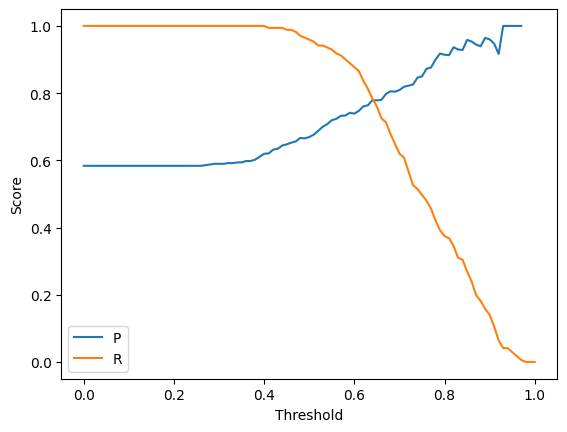

In [100]:
plt.plot(df_scores.ths, df_scores.p, label="P")
plt.plot(df_scores.ths, df_scores.r, label="R")

plt.xlabel("Threshold")
plt.ylabel("Score")

plt.legend()

**Q4: F1 score**

In [101]:
df_scores["f1"] = 2 * (df_scores.p * df_scores.r) / (df_scores.p + df_scores.r)

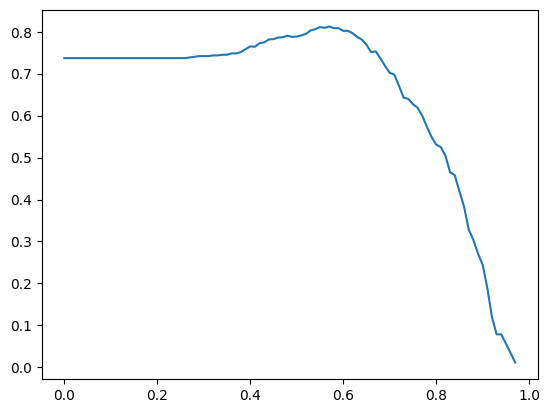

In [103]:
plt.plot(df_scores.ths, df_scores.f1)

In [107]:
df_scores[df_scores.f1 == df_scores.f1.max()]

,ths,tp,tn,fp,fn,p,r,f1
57,0.57,156,65,57,15,0.732394,0.912281,0.8125


**Q5: 5-Fold CV**

In [108]:
from sklearn.model_selection import KFold

In [116]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []

for train_idx, val_idx in kf.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.converted.values
    y_val = df_val.converted.values

    dv, model = train_model(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    score = roc_auc_score(y_val, y_pred)
    scores.append(score)

In [120]:
np.mean(scores).round(3), np.std(scores).round(3)

(np.float64(0.822), np.float64(0.036))

**Q6: Hyperparameter Tuning**

In [121]:
for C in [0.000001, 0.001, 1]:
    kf = KFold(n_splits=5, shuffle=True, random_state=1)
    scores = []
    
    for train_idx, val_idx in kf.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
    
        y_train = df_train.converted.values
        y_val = df_val.converted.values
    
        dv, model = train_model(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
    
        score = roc_auc_score(y_val, y_pred)
        scores.append(score)

    print(f"{C} >> {np.mean(scores).round(3), np.std(scores).round(3)}")

1e-06 >> (np.float64(0.56), np.float64(0.024))
0.001 >> (np.float64(0.867), np.float64(0.029))
1 >> (np.float64(0.822), np.float64(0.036))
